In [1]:
import pandas as pd
from os.path import join

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
from icecream import ic

In [4]:
n_donors = 4
mult_dir = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex"
don_dir = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0"
af_f = ""
cov_f = ""
d = 0
samples = "Control,Flt3l"
mt_genome="/data/Mito_Trace/data/external/GRCh38_MT_blacklist/chrM.fasta"

In [5]:
samples = samples.split(",")

In [6]:
from src.utils import variant_utils as vu

vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
vcf

,#CHROM,POS,REF,ALT,index
0,MT,10086,A_10086,G,1
1,MT,10318,T_10318,C,2
2,MT,10373,G_10373,A,3
3,MT,10398,A_10398,G,4
4,MT,103,G_103,A,5
...,...,...,...,...,...
215,MT,9449,C_9449,T,216
216,MT,9523,T_9523,G,217
217,MT,9540,T_9540,C,218
218,MT,9545,A_9545,G,219


In [7]:
variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
variants_meta = vu.type_of_variants(variants_meta.index)
variants_meta["ID"] = variants_meta.index
variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
variants_meta

,position,ref,alt,variant type,variant change,ID
10086G,10086,A,G,Transition,A>G,10086A>G
10318C,10318,T,C,Transition,T>C,10318T>C
10373A,10373,G,A,Transition,G>A,10373G>A
10398G,10398,A,G,Transition,A>G,10398A>G
103A,103,G,A,Transition,G>A,103G>A
...,...,...,...,...,...,...
9449T,9449,C,T,Transition,C>T,9449C>T
9523G,9523,T,G,Transversion,T>G,9523T>G
9540C,9540,T,C,Transition,T>C,9540T>C
9545G,9545,A,G,Transition,A>G,9545A>G


## Variant allele-frequency thresholds and coverage thresholds parameters

In [8]:
# thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
# read_thresh = [2, 10, 25, 50, 100]
thresholds = [0.1, 0.25]#
read_thresh = [25, 50]
cells_thresh=10
ref_cells_thresh=500

## Load af, cov, and cells_meta

In [9]:
af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
print(af.shape)
af.head()

(4205, 220)


,10086G,10318C,10373A,10398G,103A,10400T,1040C,10634C,10644A,1082G,...,9098C,9173A,9254G,9340G,9385C,9449T,9523G,9540C,9545G,9658G
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGTCGTGAG-1_Control,0.222222,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,1.000000,0.0,...,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.916667,0.958333,0.0
AAACGAACACAATAAG-1_Control,0.000000,0.0,0.0,0.953488,0.0,0.952381,0.0,0.0,1.000000,0.0,...,1.000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0
AAACGAAGTAAGTCTC-1_Control,0.000000,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,1.000000,0.0,...,1.000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0
AAACGAAGTGGATTCT-1_Control,0.000000,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.987179,0.0,...,0.975,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0
AAACGAATCGCAACTA-1_Control,0.060606,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,1.000000,0.0,...,1.000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.992308,0.0


In [10]:
cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
ic(cells_meta.shape)
cells_meta = cells_meta.loc[af.index]
ic("After filtering on af indices", cells_meta.shape)

ic| cells_meta.shape: (4205, 6)
ic| 'After filtering on af indices', cells_meta.shape: (4205, 6)


('After filtering on af indices', (4205, 6))

In [11]:
cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
print(cov.shape)
cov.head()

(4205, 220)


,10086G,10318C,10373A,10398G,103A,10400T,1040C,10634C,10644A,1082G,...,9098C,9173A,9254G,9340G,9385C,9449T,9523G,9540C,9545G,9658G
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGTCGTGAG-1_Control,9.0,18.0,16.0,10.0,19.0,10.0,14.0,33.0,33.0,11.0,...,23.0,20.0,35.0,18.0,32.0,35.0,18.0,24.0,24.0,39.0
AAACGAACACAATAAG-1_Control,22.0,75.0,63.0,43.0,66.0,42.0,46.0,89.0,83.0,29.0,...,39.0,71.0,69.0,58.0,57.0,76.0,51.0,45.0,40.0,55.0
AAACGAAGTAAGTCTC-1_Control,9.0,8.0,11.0,11.0,13.0,11.0,24.0,36.0,31.0,1.0,...,14.0,14.0,16.0,8.0,16.0,20.0,21.0,27.0,23.0,13.0
AAACGAAGTGGATTCT-1_Control,31.0,63.0,56.0,37.0,70.0,36.0,47.0,80.0,78.0,51.0,...,40.0,93.0,49.0,42.0,72.0,77.0,57.0,50.0,52.0,81.0
AAACGAATCGCAACTA-1_Control,99.0,225.0,214.0,179.0,196.0,178.0,199.0,276.0,283.0,240.0,...,214.0,201.0,188.0,218.0,223.0,277.0,253.0,269.0,260.0,211.0


## Functions for creating the variant dfs

In [12]:
def is_af_in_cell(cell_var, t, rt=None, is_af_above=True, check_cov=False):
    """
    Checks which cells pass the thresholds using the af and cov columns
    """
    if check_cov:
        return cell_var[cell_var["cov"]>rt].index
    if is_af_above:
        if rt is None:
            return cell_var[cell_var["af"] > t].index
        else:
            return cell_var[(cell_var["af"] > t) & (cell_var["cov"] > rt)].index
    else:
        if rt is None:
            return cell_var[cell_var["af"] < t].index
        else:
            return cell_var[(cell_var["af"] < t) & (cell_var["cov"] > rt)].index        
    return

In [13]:
def calc_variant_descriptives(cells_df, name, prefix=""):#, t, rt, 
    vars_ser = {}
    vars_ser[f"{prefix}{name}_median"] = cells_df["af"].median()
    vars_ser[f"{prefix}{name}_mean"] = cells_df["af"].mean(axis=0)
    vars_ser[f"{prefix}{name}_coverage_median"] = cells_df["cov"].median()
    vars_ser[f"{prefix}{name}_coverage_mean"] = cells_df["cov"].mean()
    vars_ser[f"{prefix}{name}_nCells"] = len(cells_df)
    return pd.Series(vars_ser)


## Setup the variants_df columns

In [14]:
def set_keys(cols, curr):
    keys = ["_median", "_mean", "_nCells", "_coverage_median", "_coverage_mean"]
    for k in keys:
        cols.append(f"{curr}{k}")
    return cols


def add_columns(columns, thresholds, read_thresh, sample=None):
    if sample is None:
        prefix = ""
    else:
        prefix=f"cond{sample}_"

    for t in thresholds:
        #columns.append(t)
        columns = set_keys(columns, f"{prefix}{t}" )
        for rt in read_thresh:
            columns = set_keys(columns, f"{prefix}{t}_{rt}" )
            columns = set_keys(columns, f"{prefix}{t}_{rt}_refPassCov" )
    return columns


# columns = []
# columns = add_columns(columns, thresholds, read_thresh)
# for s in samples:
#     columns = add_columns(columns, thresholds, read_thresh, sample=s)
# columns

## Create two variant-centric variables:
a) variants_df: dataframe where index is the variants and columns are clone metrics for each variant, and the column labels contain the parameter information (e.g. {thresholdA}\_{read_thresholdB})  
b) variants_cell_index: dict(key=variant, value=dictionary:key=params tuple, value=passed cell indices)

In [15]:
#########################
## Add in sample information
#########################


def get_variant_info(curr_af, curr_cov, columns, prefix=""):
    variants_cell_index_d = {}
    variants_df_init = {}

    for v in variants:
        #print('variant', v)
        curr_v_d = {}
        variants_d = {}
        
        
        # create cell-by-(af,cov) df to pass into summary functions
        curr_v_df = pd.concat((curr_af.loc[:,[v]].rename({v:"af"}, axis=1),
                               curr_cov.loc[:,[v]].rename({v:"cov"}, axis=1)), axis=1)
        for t in thresholds:
            if prefix == "":
                t_key = t
            else:
                t_key = (t, prefix)
            curr_v_d[t_key] = is_af_in_cell(curr_v_df, t, rt=None, is_af_above=True, check_cov=False)

            variants_d[t_key] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[t_key]], name=f"{prefix}{t}")
            for rt in read_thresh:
                if prefix == "":
                    trt_key = (t,rt)
                    reftrt_key = (t, rt, "ref_pass_cov")
                else:
                    trt_key = (t,rt, prefix) 
                    reftrt_key = (t, rt, prefix, "ref_pass_cov")
                
                curr_v_d[trt_key] = is_af_in_cell(curr_v_df, t, rt=rt, is_af_above=True, check_cov=False)
                variants_d[trt_key] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[trt_key]], 
                                                                     name=f"{prefix}{t}_{rt}")
                #ic(trt_key)
                #ic(variants_d[trt_key].head())
                curr_v_d[reftrt_key] = is_af_in_cell(curr_v_df, t, rt=rt, 
                                                                 is_af_above=False, check_cov=False)
                variants_d[reftrt_key] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[reftrt_key]], 
                                                                               name=f"{prefix}{t}_{rt}_refPassCov"
                                                                               )
                    
        for rt in read_thresh:
            if prefix == "":
                rt_key = (rt, "pass_cov")
            else:
                rt_key = (rt,  "pass_cov", prefix)
            curr_v_d[rt_key] = is_af_in_cell(curr_v_df, t=None, rt=rt, is_af_above=False, check_cov=True)
            variants_d[rt_key] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[rt_key]], 
                                                                                 name=f"{prefix}{rt}_passCov")
        variants_cell_index_d[v] = curr_v_d 
        variants_df_init[v] = variants_d    
     


    # Combine all the variants from the dictionary
    variants_df = pd.DataFrame(index=variants, columns = columns)
    for v in variants_df_init:
        variants_df.loc[v] = pd.concat([val for val in variants_df_init[v].values()])

    variants_df[f"{prefix}median"] = curr_af.median()
    variants_df[f"{prefix}mean"] = curr_af.mean()
    variants_df[f"{prefix}median_cov"] = curr_cov.median()
    variants_df[f"{prefix}mean_cov"] = curr_cov.mean()
    return variants_df, variants_cell_index_d, variants_df_init


In [16]:
variants = set(af.columns)
variants_cell_index_d = {}
#variants_df_init = {}
columns = add_columns([], thresholds, read_thresh)

variants_df, variants_cell_index_d, _ = get_variant_info(af, cov, columns=columns, prefix="")

for sample, curr_cells_meta in cells_meta.groupby("condition"):
    print(sample)
    print(curr_cells_meta.shape)
    
    curr_af = af.loc[curr_cells_meta.index]
    curr_cov = cov.loc[curr_cells_meta.index]
    curr_cols = add_columns([], thresholds, read_thresh, sample=sample)
    columns += curr_cols
    curr_variants_df, curr_index_d, curr_variants_df_init = get_variant_info(curr_af, curr_cov, columns=curr_cols,
                                                               prefix=f"cond{sample}_")
    variants_df = pd.concat((variants_df, curr_variants_df), axis=1)
    
    for v in curr_index_d.keys(): 
        for k in curr_index_d[v].keys():
            assert(k not in variants_cell_index_d[v].keys())
            variants_cell_index_d[v][k] = curr_index_d[v][k]
    

Control
(1623, 6)
Flt3l
(2582, 6)


In [17]:
# curr_cells_meta = cells_meta["condition"] == "Flt3l"
# sample = "Flt3l"
# curr_af = af.loc[curr_cells_meta.index]
# curr_cov = cov.loc[curr_cells_meta.index]
# curr_cols = add_columns([], thresholds, read_thresh, sample=sample)
# columns += curr_cols
# curr_variants_df, curr_index_d, curr_variants_df_init = get_variant_info(curr_af, curr_cov, columns=curr_cols,
#                                                            prefix=f"cond{sample}_")

In [18]:
variants_df = pd.merge(variants_meta, variants_df, left_index=True, right_index=True, how="right")

In [19]:
# variants = set(af.columns)
# variants_cell_index_d = {}
# variants_df_init = {}
# for v in variants:
#     print('variant', v)
#     curr_v_d = {}
#     variants_d = {}
    
#     # create cell-by-(af,cov) df to pass into summary functions
#     curr_v_df = pd.concat((af.loc[:,[v]].rename({v:"af"}, axis=1),
#                            cov.loc[:,[v]].rename({v:"cov"}, axis=1)), axis=1)

#     for t in thresholds:
#         curr_v_d[t] = is_af_in_cell(curr_v_df, t, rt=None, is_af_above=True, check_cov=False)
#         variants_d[t] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[t]], name=f"{t}")
        
#         for rt in read_thresh:
#             curr_v_d[(t,rt)] = is_af_in_cell(curr_v_df, t, rt=rt, is_af_above=True, check_cov=False)
#             variants_d[(t,rt)] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[(t,rt)]], 
#                                                                  name=f"{t}_{rt}")
            
#             curr_v_d[(t,rt, "ref_pass_cov")] = is_af_in_cell(curr_v_df, t, rt=rt, 
#                                                              is_af_above=False, check_cov=False)
#             variants_d[(t,rt, "ref_pass_cov")] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[(t,rt, "ref_pass_cov")]], 
#                                                                                  name=f"{t}_{rt}_refPassCov")
            
#     for rt in read_thresh:
#         curr_v_d[(rt, "pass_cov")] = is_af_in_cell(curr_v_df, t=None, rt=rt, is_af_above=False, check_cov=True)
#         variants_d[(rt, "pass_cov")] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[(rt, "pass_cov")]], 
#                                                                              name=f"{rt}_passCov")
#     variants_cell_index_d[v] = curr_v_d 
#     variants_df_init[v] = variants_d

# # Combine all the variants from the dictionary
# variants_df = pd.DataFrame(index=variants, columns = columns)
# for v in variants_df_init:
#     variants_df.loc[v] = pd.concat([val for val in variants_df_init[v].values()])

# variants_df["median"] = af.median()
# variants_df["mean"] = af.mean()

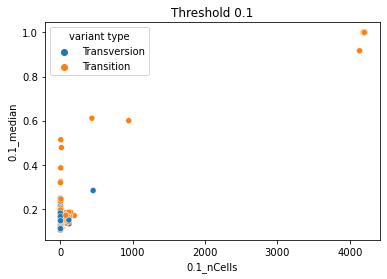

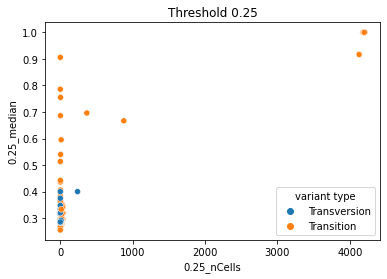

In [20]:
for t in thresholds:
    f = plt.figure()
    sns.scatterplot(x=f"{t}_nCells",y=f"{t}_median",data=variants_df, hue="variant type")#.astype(float))
    plt.title(f"Threshold {t}")

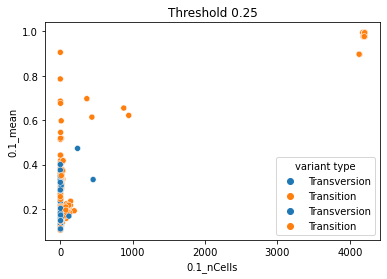

In [21]:
for t in thresholds:
    sns.scatterplot(x=f"{t}_nCells",y=f"{t}_mean",data=variants_df, hue="variant type")
    plt.title(f"Threshold {t}")

## Remove high variants

In [22]:
variants_df = variants_df[~(variants_df["median"] > 0.6)]

In [23]:
variants_df.head()

,position,ref,alt,variant type,variant change,ID,0.1_median,0.1_mean,0.1_nCells,0.1_coverage_median,...,condFlt3l_0.25_50_coverage_mean,condFlt3l_0.25_50_refPassCov_median,condFlt3l_0.25_50_refPassCov_mean,condFlt3l_0.25_50_refPassCov_nCells,condFlt3l_0.25_50_refPassCov_coverage_median,condFlt3l_0.25_50_refPassCov_coverage_mean,condFlt3l_median,condFlt3l_mean,condFlt3l_median_cov,condFlt3l_mean_cov
6470C,6470,A,C,Transversion,A>C,6470A>C,0.238095,0.238095,2.0,10.0,...,NaN,0.0,0.00134,1819.0,95.0,110.391974,0.0,0.001186,73.0,87.925252
14971C,14971,T,C,Transition,T>C,14971T>C,0.167949,0.216583,4.0,35.0,...,NaN,0.0,0.00134,1664.0,90.0,104.946514,0.0,0.001185,67.0,79.698683
6109C,6109,T,C,Transition,T>C,6109T>C,0.155695,0.18606,6.0,22.0,...,NaN,0.0,0.001557,1490.0,83.0,95.731544,0.0,0.001604,58.0,68.744771
16183C,16183,A,C,Transversion,A>C,16183A>C,0.215909,0.215909,2.0,20.5,...,NaN,0.0,0.000376,1168.0,75.0,86.310788,0.0,0.000419,46.0,55.251356
3508G,3508,A,G,Transition,A>G,3508A>G,0.142857,0.133989,3.0,19.0,...,NaN,0.0,0.000926,1653.0,89.0,103.015729,0.0,0.000826,65.0,77.738575


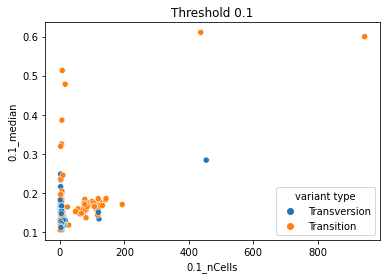

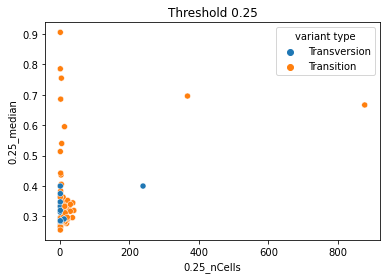

In [24]:
for t in thresholds:
    f = plt.figure()
    sns.scatterplot(x=f"{t}_nCells",y=f"{t}_median",data=variants_df, hue="variant type")#.astype(float))
    plt.title(f"Threshold {t}")

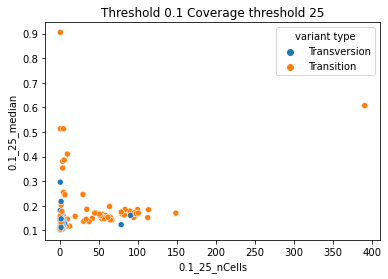

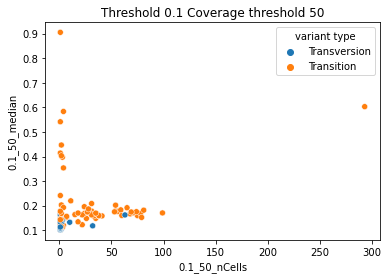

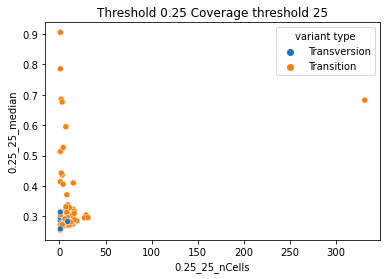

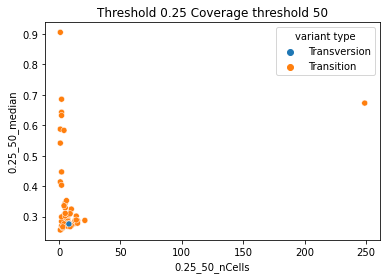

In [25]:
for t in thresholds:
    for rt in read_thresh:
        f = plt.figure()
        sns.scatterplot(x=f"{t}_{rt}_nCells",y=f"{t}_{rt}_median",data=variants_df, hue="variant type")#.astype(float))
        plt.title(f"Threshold {t} Coverage threshold {rt}")

In [26]:
# def create_cluster_size(variants_df, cells_thresh, ref_cells_thresh):
#     inds = [f"{t}_{rt}_nCells" for t in thresholds for rt in read_thresh]
#     cluster_size_df = pd.DataFrame(index=inds, columns=["nClones", "nClones_and_nRef"])#, "fold_nClones_nRef"])
#     for t in thresholds:
#         for rt in read_thresh:
#             cluster_size_df.loc[f"{t}_{rt}_nCells","nClones"] = (variants_df[f"{t}_{rt}_nCells"] > cells_thresh).sum()
                                                      
#             cluster_size_df.loc[f"{t}_{rt}_nCells","nClones_and_nRef"] = ((variants_df[f"{t}_{rt}_nCells"] > cells_thresh) & 
#                                                                   (variants_df[f"{t}_{rt}_refPassCov_nCells"] > ref_cells_thresh)).sum() 
            
# #             fold_nClones_nRef = variants_df[((variants_df.loc["{t}_{rt}_nCells"] > cells_thresh) & 
# #                                                                   (variants_df.loc["{t}_{rt}_refPassCov_nCells"] > ref_cells_thresh))
#     f=plt.figure()
#     sns.heatmap(cluster_size_df.astype(int))
#     plt.title(f"#Variants detected \ncells in clone >= {cells_thresh} cells in ref >= {ref_cells_thresh}")
#     return cluster_size_df

# cluster_size_df = create_cluster_size(variants_df, cells_thresh=10, ref_cells_thresh=50)
# cluster_size_df

# cluster_size_df = create_cluster_size(variants_df, cells_thresh=10, ref_cells_thresh=500)


## Get clone sizes using clones that passed the filter

In [27]:
def create_cluster_size(variants_df, cells_thresh, ref_cells_thresh):
    inds = [f"{t}_{rt}_nCells" for t in thresholds for rt in read_thresh]
    num_vars_df = pd.DataFrame(index=inds, columns=["nClones", "nClones_and_nRef"])#, "fold_nClones_nRef"])
    clone_sizes_d = {}
    for t in thresholds:
        for rt in read_thresh:
            num_vars_df.loc[f"{t}_{rt}_nCells","nClones"] = (variants_df[f"{t}_{rt}_nCells"] > cells_thresh).sum()
                                                      
            num_vars_df.loc[f"{t}_{rt}_nCells","nClones_and_nRef"] = ((variants_df[f"{t}_{rt}_nCells"] > cells_thresh) & 
                                                                  (variants_df[f"{t}_{rt}_refPassCov_nCells"] > ref_cells_thresh)).sum() 
            
            passed_vars = variants_df.loc[((variants_df[f"{t}_{rt}_nCells"] > cells_thresh) & 
                                          (variants_df[f"{t}_{rt}_refPassCov_nCells"] > ref_cells_thresh))].index 
            curr_clone_sizes_d = pd.DataFrame(index=passed_vars, columns=["clone_sizes", "ref_sizes", "param"])
            curr_clone_sizes_d["param"] = f"{t}_{rt}"
            curr_clone_sizes_d["clone_sizes"] =  variants_df.loc[passed_vars, f"{t}_{rt}_nCells"]
            curr_clone_sizes_d["ref_sizes"] =  variants_df.loc[passed_vars, f"{t}_{rt}_refPassCov_nCells"]
            curr_clone_sizes_d["clone_plus_ref_sizes"] = curr_clone_sizes_d["clone_sizes"] + curr_clone_sizes_d["ref_sizes"]
            curr_clone_sizes_d["relative_size"] = curr_clone_sizes_d["clone_sizes"]/curr_clone_sizes_d["ref_sizes"]
            curr_clone_sizes_d["variant"] = passed_vars
            clone_sizes_d[(t, rt)] = curr_clone_sizes_d 
#             fold_nClones_nRef = variants_df[((variants_df.loc["{t}_{rt}_nCells"] > cells_thresh) & 
#                                                                   (variants_df.loc["{t}_{rt}_refPassCov_nCells"] > ref_cells_thresh))
#     f=plt.figure()
#     sns.heatmap(num_vars_df.astype(int))
#     plt.title(f"#Variants detected \ncells in clone >= {cells_thresh} cells in ref >= {ref_cells_thresh}")
    return clone_sizes_d, num_vars_df

In [28]:
clone_sizes_d, num_vars_df = create_cluster_size(variants_df, cells_thresh=10, ref_cells_thresh=500)
clone_sizes_d = pd.concat(clone_sizes_d, ignore_index=True)
clone_sizes_d

,clone_sizes,ref_sizes,param,clone_plus_ref_sizes,relative_size,variant
0,42.0,3038.0,0.1_25,3080.0,0.013825,16111T
1,38.0,3318.0,0.1_25,3356.0,0.011453,16290T
2,79.0,2796.0,0.1_25,2875.0,0.028255,290T
3,54.0,3667.0,0.1_25,3721.0,0.014726,64T
4,67.0,3609.0,0.1_25,3676.0,0.018565,12007A
...,...,...,...,...,...,...
113,249.0,2393.0,0.25_50,2642.0,0.104053,11149A
114,21.0,2330.0,0.25_50,2351.0,0.009013,16519C
115,13.0,2799.0,0.25_50,2812.0,0.004645,3450T
116,15.0,2709.0,0.25_50,2724.0,0.005537,3278C


In [29]:
clone_sizes_d_c10_ref50, num_vars_df_c10_ref50 = create_cluster_size(variants_df, cells_thresh=10, ref_cells_thresh=50)
clone_sizes_d_c10_ref50 = pd.concat(clone_sizes_d_c10_ref50, ignore_index=True)
clone_sizes_d_c10_ref50

,clone_sizes,ref_sizes,param,clone_plus_ref_sizes,relative_size,variant
0,42.0,3038.0,0.1_25,3080.0,0.013825,16111T
1,38.0,3318.0,0.1_25,3356.0,0.011453,16290T
2,79.0,2796.0,0.1_25,2875.0,0.028255,290T
3,54.0,3667.0,0.1_25,3721.0,0.014726,64T
4,67.0,3609.0,0.1_25,3676.0,0.018565,12007A
...,...,...,...,...,...,...
115,249.0,2393.0,0.25_50,2642.0,0.104053,11149A
116,21.0,2330.0,0.25_50,2351.0,0.009013,16519C
117,13.0,2799.0,0.25_50,2812.0,0.004645,3450T
118,15.0,2709.0,0.25_50,2724.0,0.005537,3278C


Text(0.5, 1.0, '#Variants detected \ncells in clone >= 10 cells in ref >= 500')

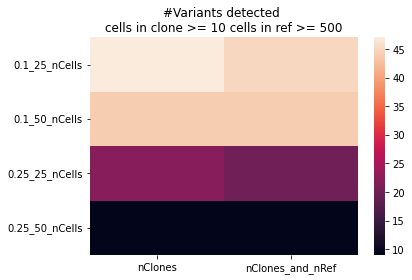

In [30]:
f=plt.figure()
sns.heatmap(num_vars_df.astype(int))
plt.title(f"#Variants detected \ncells in clone >= {cells_thresh} cells in ref >= {ref_cells_thresh}")

## Number of clones across different AF+coverage thresholds
(2 other parameters, min_cells=10 and ref_cells_thresh=500 are used here, which are the thresholds for the cluster sizes and the reference variant being covered by a sufficient number of cells)

Text(0.5, 1.0, 'Number of clones detected\nminimum cells=10, ref_cells_thresh=500')

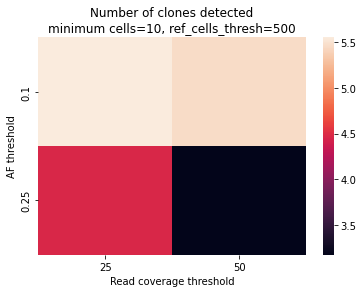

In [31]:

num_vars_mat_df = pd.DataFrame(index=thresholds,columns=read_thresh, dtype=int)
for t in thresholds:
    for rt in read_thresh:
        num_vars_mat_df.loc[t,rt] = num_vars_df.loc[f"{t}_{rt}_nCells","nClones"]
sns.heatmap(np.log2(num_vars_mat_df))
plt.ylabel("AF threshold")
plt.xlabel("Read coverage threshold")
plt.title(f"Number of clones detected\nminimum cells={cells_thresh}, ref_cells_thresh={ref_cells_thresh}")
# add size of each to reflect number of cells total

In [32]:
log2_clone_sizes_d = np.log2(clone_sizes_d[["clone_sizes", "ref_sizes", "clone_plus_ref_sizes"]].astype(int))
log2_clone_sizes_d["relative_size"] = log2_clone_sizes_d["clone_sizes"]/log2_clone_sizes_d["ref_sizes"]
log2_clone_sizes_d["param"] = clone_sizes_d["param"]
log2_clone_sizes_d["variant"] = clone_sizes_d["variant"]
log2_clone_sizes_d

,clone_sizes,ref_sizes,clone_plus_ref_sizes,relative_size,param,variant
0,5.392317,11.568906,11.588715,0.466104,0.1_25,16111T
1,5.247928,11.696098,11.712527,0.448690,0.1_25,16290T
2,6.303781,11.449149,11.489346,0.550589,0.1_25,290T
3,5.754888,11.840385,11.861475,0.486039,0.1_25,64T
4,6.066089,11.817383,11.843921,0.513319,0.1_25,12007A
...,...,...,...,...,...,...
113,7.960002,11.224605,11.367415,0.709157,0.25_50,11149A
114,4.392317,11.186114,11.199059,0.392658,0.25_50,16519C
115,3.700440,11.450696,11.457381,0.323163,0.25_50,3450T
116,3.906891,11.403545,11.411511,0.342603,0.25_50,3278C


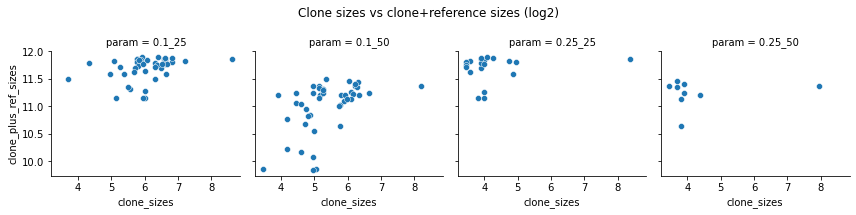

In [33]:
g = sns.FacetGrid(data=log2_clone_sizes_d,col="param", col_wrap=4)
g.map(sns.scatterplot, "clone_sizes", "clone_plus_ref_sizes")
g.fig.suptitle("Clone sizes vs clone+reference sizes (log2)")
plt.tight_layout()

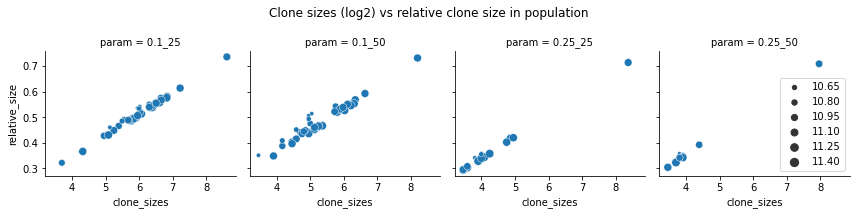

In [34]:
g = sns.FacetGrid(data=log2_clone_sizes_d,col="param", col_wrap=4)
g.map_dataframe(sns.scatterplot, "clone_sizes", "relative_size", size="ref_sizes")
plt.legend()
g.fig.suptitle("Clone sizes (log2) vs relative clone size in population")
plt.tight_layout()

## For each parameter, rank clones by i) highest nCells and ii) highest nRef
## Create df where index is cell and columns are 'variant,' 'isClone', 'af' 
### To do this, use variants dict of passed indices
## For each variant plot the distribution and hue=isClone


In [35]:
def create_distributions(t, rt, variants_cell_index_d, af, clone_thresh, ref_cells_thresh, prefix=""):
    ic(t,rt)
    clone_var_distributions = pd.DataFrame(columns=["variant", "isClone", "af"])
    for v in variants_cell_index_d:
        curr_v = variants_cell_index_d[v]
        curr_cells = curr_v[(t,rt)]
        curr_ref_cells = curr_v[(t,rt, "ref_pass_cov")]
            
        if len(curr_cells) < clone_thresh or len(curr_ref_cells) < ref_cells_thresh:
            #ic(f"variant {v} not pass threshold")
            continue 
        curr_clone = pd.DataFrame(index=curr_cells, columns=["variant", "isClone", "af", "param"])
        curr_clone["isClone"] = True
        curr_clone["variant"] = v
        curr_clone["param"] = f"{t}_{rt}"
        curr_clone["af"] = af.loc[curr_cells, v]
        curr_clone["cell"] = af.loc[curr_cells].index
        clone_var_distributions = pd.concat((clone_var_distributions, 
                                             curr_clone),axis=0, ignore_index=True)
        curr_ref = pd.DataFrame(index=curr_ref_cells, columns=["variant", "isClone", "af"])
        curr_ref["isClone"] = False
        curr_ref["variant"] = v
        curr_ref["param"] = f"{t}_{rt}"
        curr_ref["af"] = af.loc[curr_ref_cells, v]
        curr_ref["cell"] = af.loc[curr_ref_cells].index
        clone_var_distributions = pd.concat((clone_var_distributions, 
                                             curr_ref),axis=0, ignore_index=True)          
    return clone_var_distributions


def create_distributions_samples(t, rt, variants_cell_index_d, af, clone_thresh, ref_cells_thresh, samples):
    ic(t,rt)
    clone_var_distributions = pd.DataFrame(columns=["variant", "sample", "af", "param"])
    for v in variants_cell_index_d:
        curr_v = variants_cell_index_d[v]
        curr_cells = curr_v[(t,rt, f"cond{samples[0]}_")]
        curr_ref_cells = curr_v[(t,rt, f"cond{samples[1]}_")]
            
        if len(curr_cells) < clone_thresh or len(curr_ref_cells) < ref_cells_thresh:
            #ic(f"variant {v} not pass threshold")
            continue 
        curr_clone = pd.DataFrame(index=curr_cells, columns=["variant", "sample", "af", "param"])
        curr_clone["sample"] = samples[0]
        curr_clone["variant"] = v
        curr_clone["param"] = f"{t}_{rt}"
        curr_clone["af"] = af.loc[curr_cells, v]
        curr_clone["cell"] = af.loc[curr_cells].index
        clone_var_distributions = pd.concat((clone_var_distributions, 
                                             curr_clone),axis=0, ignore_index=True)
        curr_ref = pd.DataFrame(index=curr_ref_cells, columns=["variant", "isClone", "af"])
        curr_ref["sample"] = samples[1]
        curr_ref["variant"] = v
        curr_ref["param"] = f"{t}_{rt}"
        curr_ref["af"] = af.loc[curr_ref_cells, v]
        curr_ref["cell"] = af.loc[curr_ref_cells].index
        clone_var_distributions = pd.concat((clone_var_distributions, 
                                             curr_ref),axis=0, ignore_index=True)          
    return clone_var_distributions



In [36]:
def plot_violin(clone_var_dist, col_order, x="isClone"):
    g = sns.FacetGrid(data=clone_var_dist, col="variant", col_wrap=8, 
                      sharex=False, 
                      sharey=False,col_order=col_order)
    g.map_dataframe(sns.violinplot, x=x, y="af")    
    return g

def plot_hist(clone_var_dist, col_order, hue_col="isClone"):
    g = sns.FacetGrid(data=clone_var_distributions, col="variant", col_wrap=8, hue=hue_col,
                      sharex=False, 
                      sharey=False, col_order=col_order)
    g.map_dataframe(sns.histplot, x="af", stat="probability")
    return

def get_var_order(clone_var_dist, variants_df, t, rt):
    curr_vars = set(clone_var_dist["variant"])
    var_order = variants_df.loc[curr_vars].sort_values([f"{t}_{rt}_nCells", f"{t}_{rt}_refPassCov_nCells"], ascending=False).index
    return var_order

# def get_var_order(clone_var_dist, variants_df, t, rt):
#     curr_vars = set(clone_var_dist["variant"])
#     var_order = variants_df.loc[curr_vars].sort_values([f"{t}_{rt}_nCells", f"{t}_{rt}_refPassCov_nCells"], ascending=False).index
#     return var_order

ic| t: 0.1, rt: 25


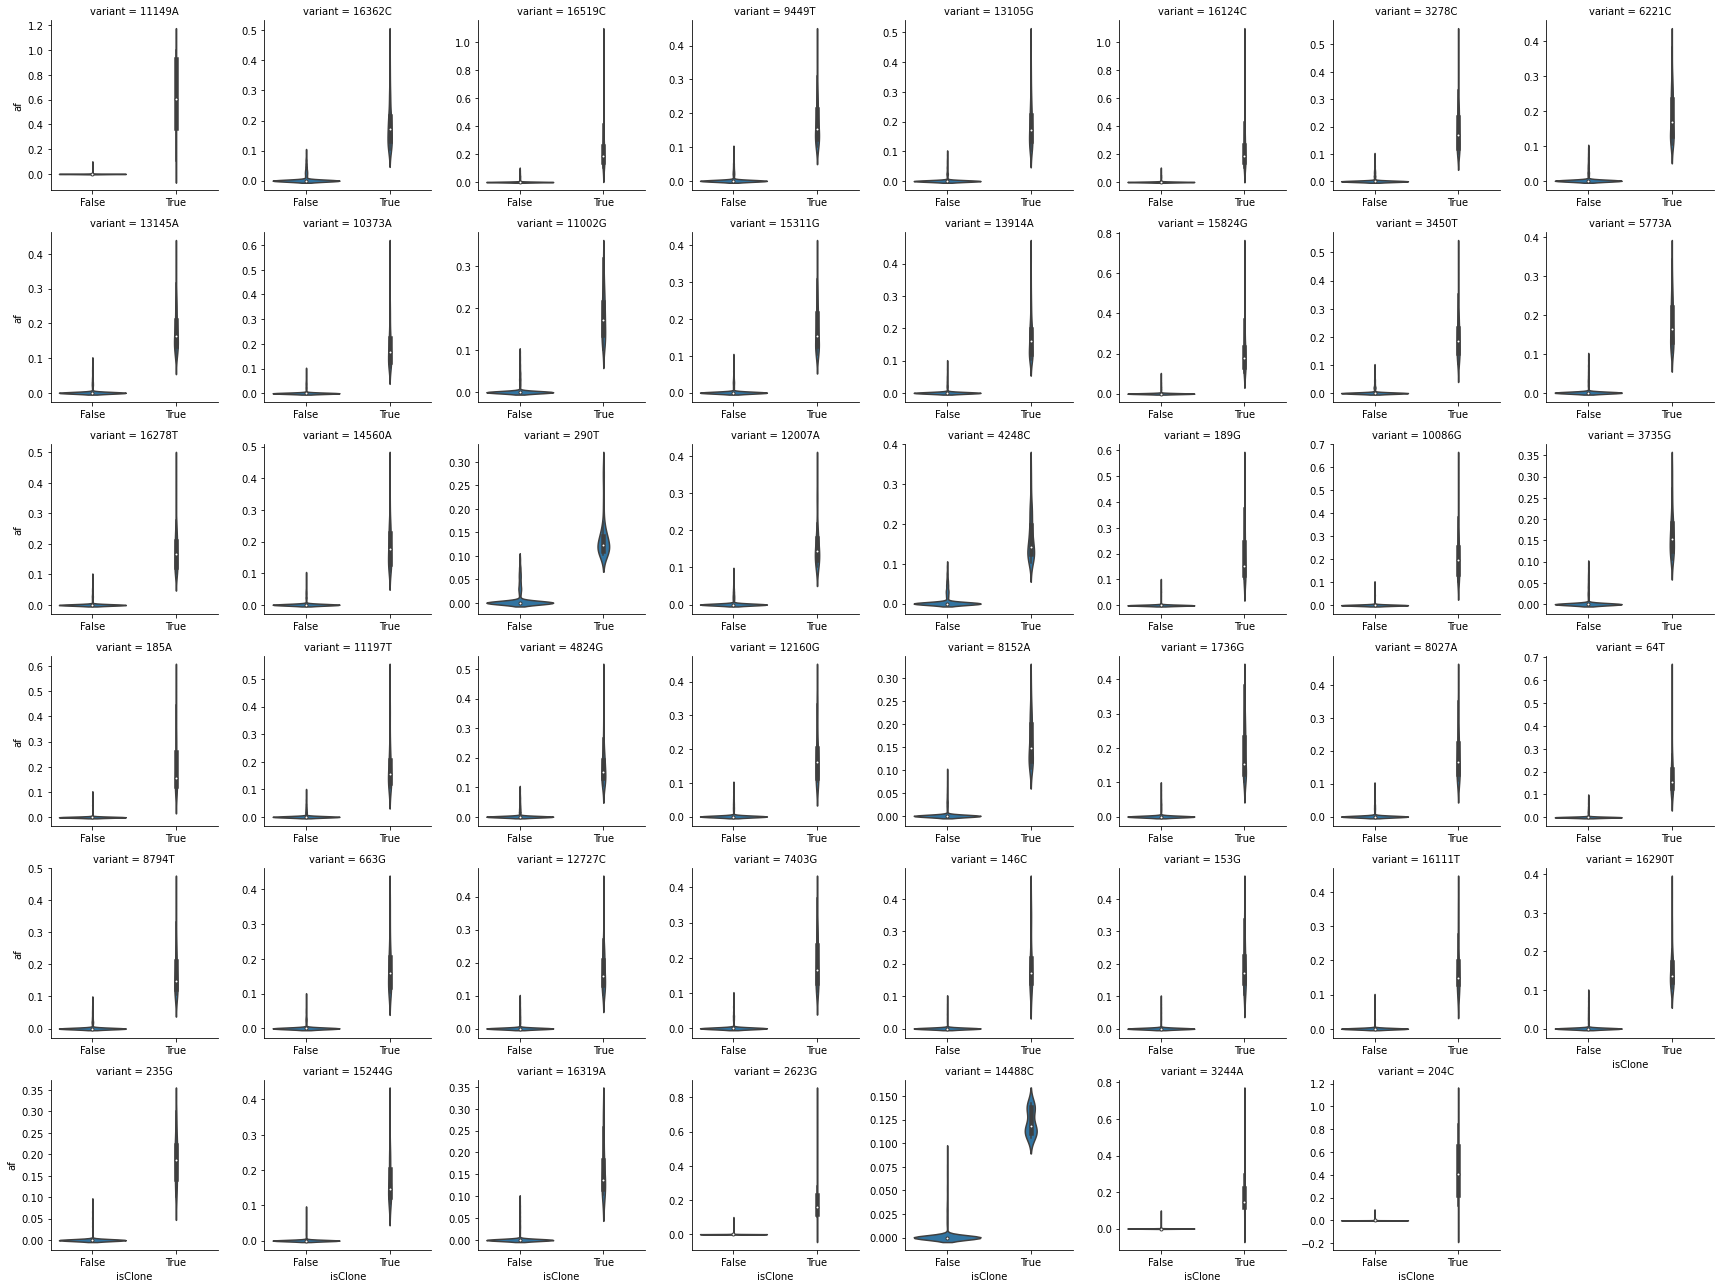

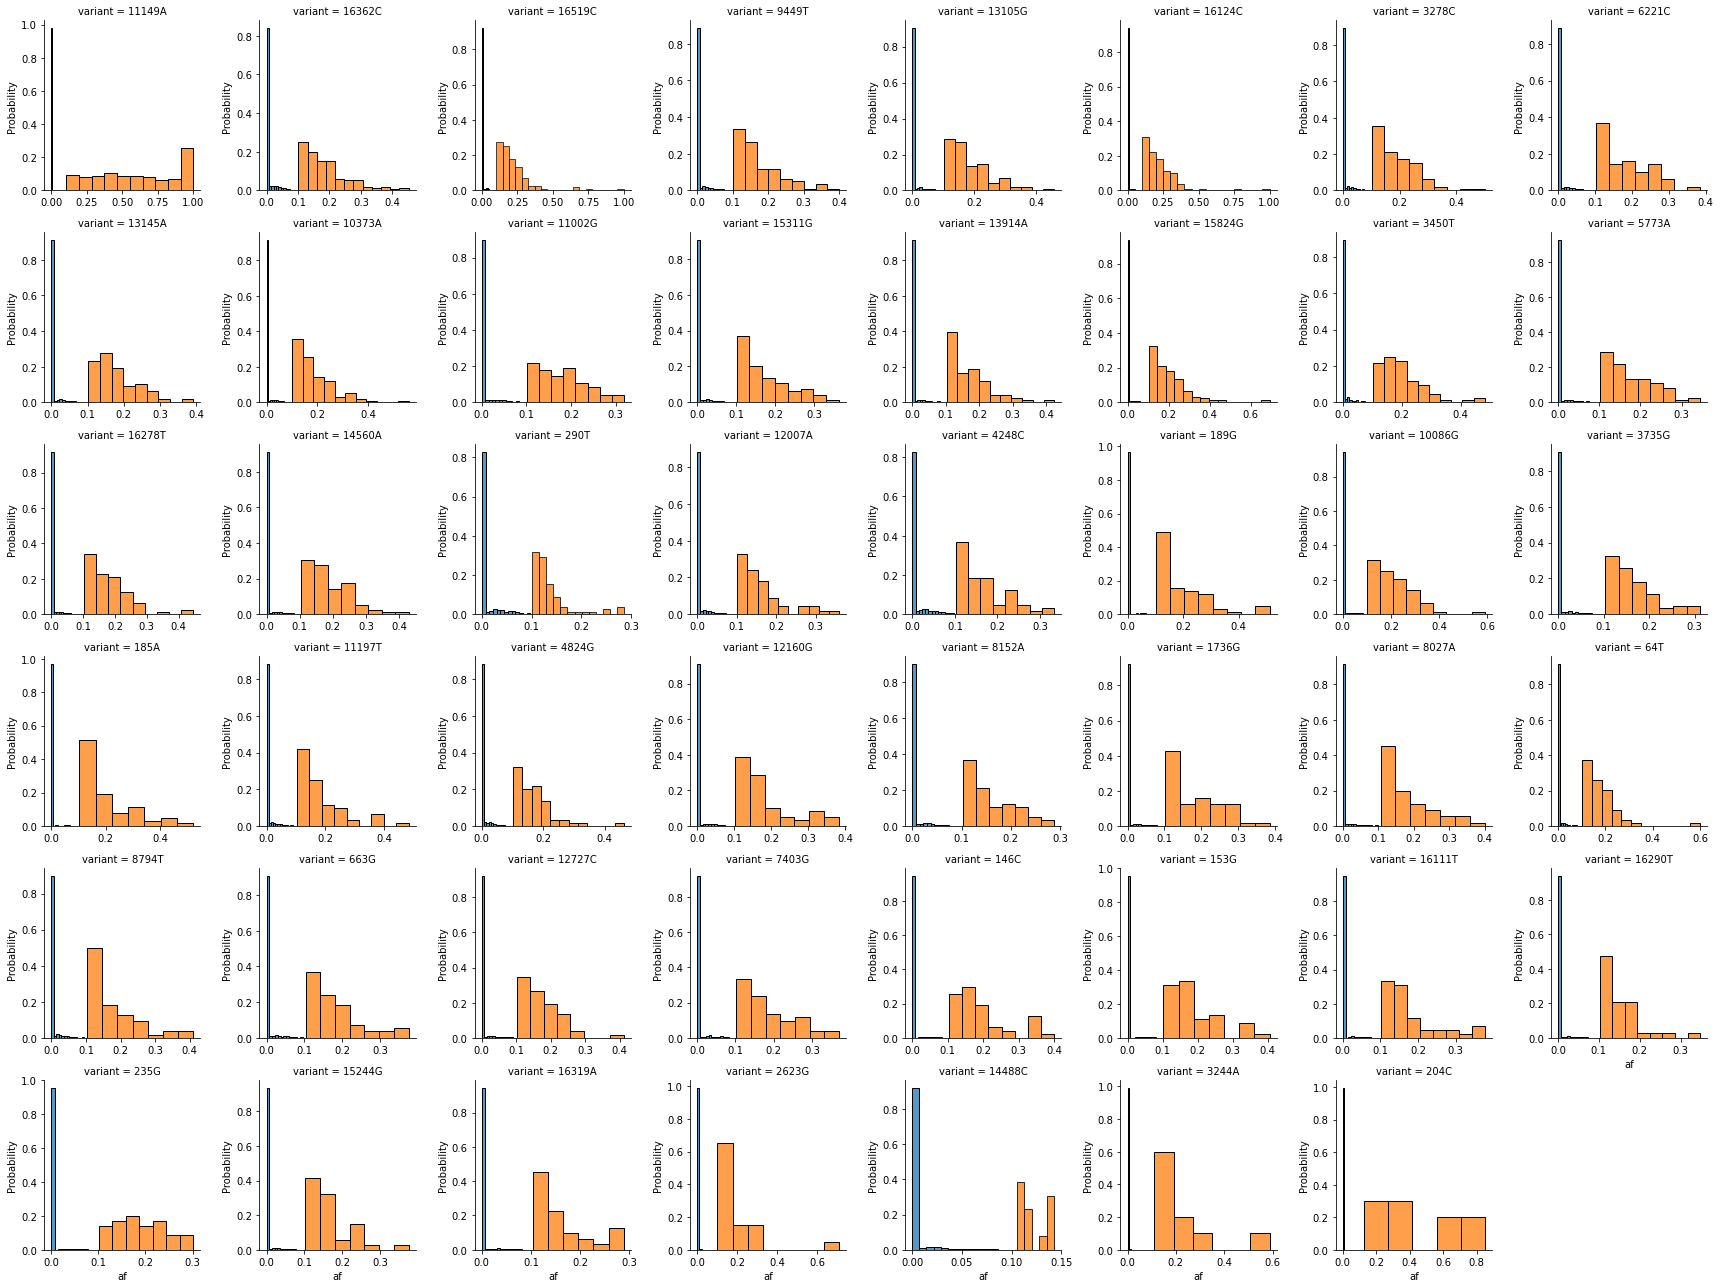

In [37]:
%matplotlib inline
t=0.1
rt=25
clone_var_distributions = create_distributions(t,rt, variants_cell_index_d, af, cells_thresh, ref_cells_thresh)  

col_order = get_var_order(clone_var_distributions, variants_df, t, rt)
g_vln = plot_violin(clone_var_distributions, col_order)
g_hist = plot_hist(clone_var_distributions, col_order)

ic| t: 0.25, rt: 25


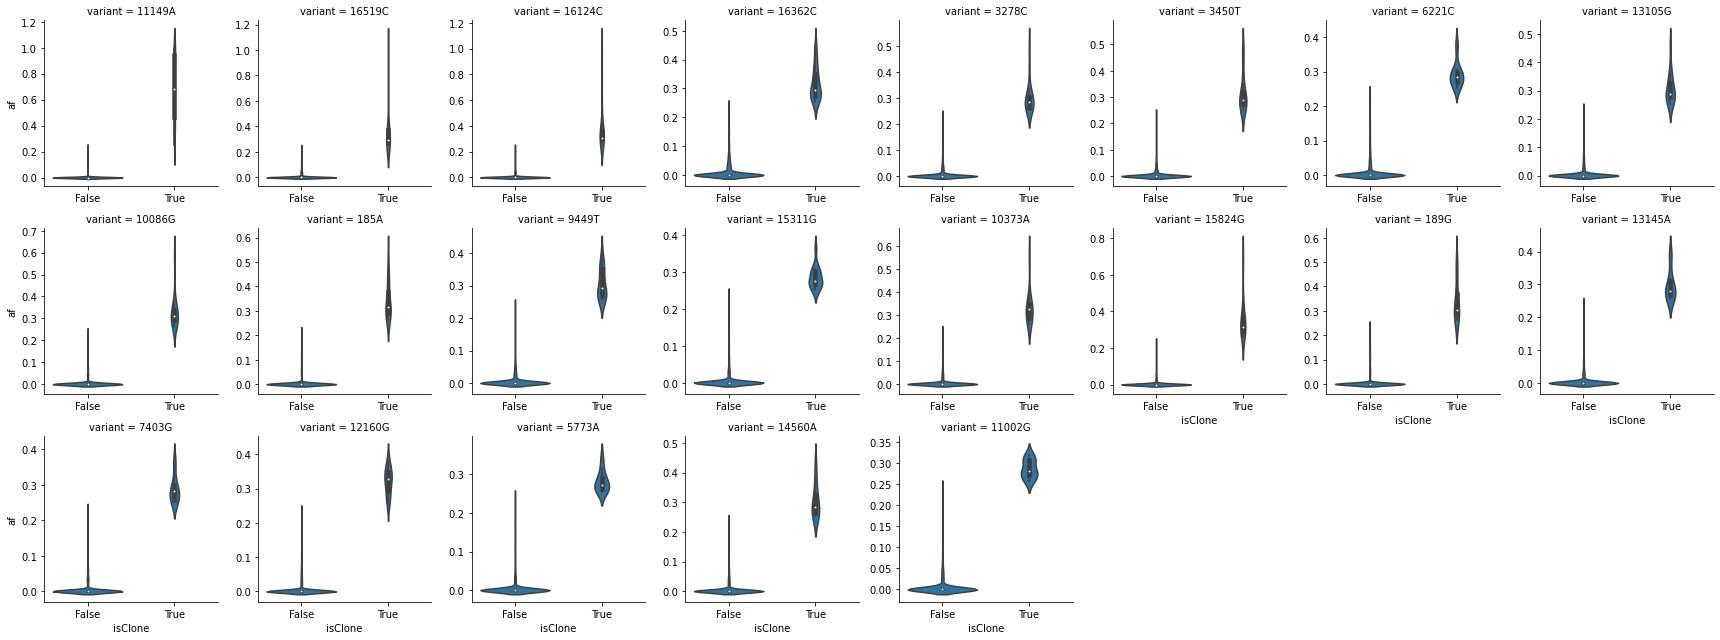

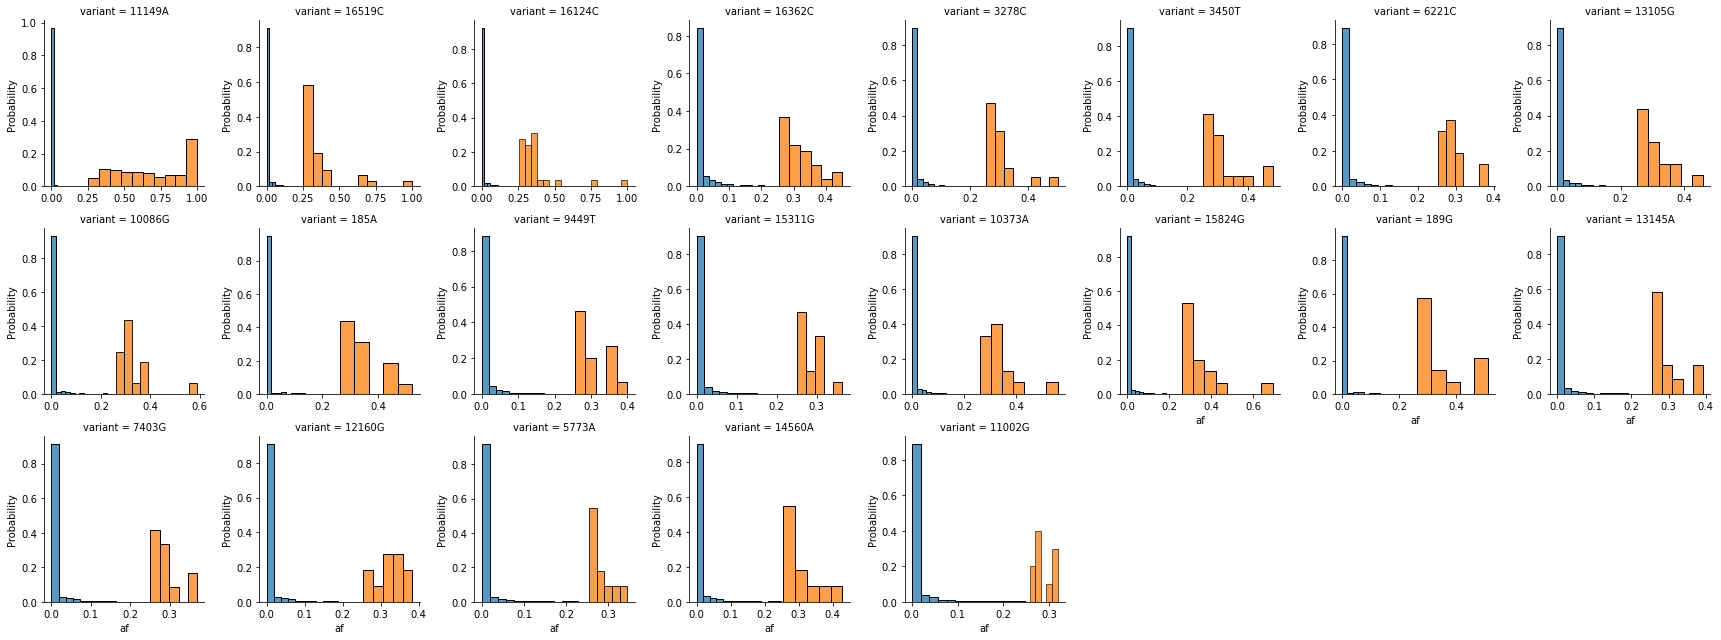

In [38]:
%matplotlib inline
t=0.25
rt=25
clone_var_distributions = create_distributions(t,rt, variants_cell_index_d, af, cells_thresh, ref_cells_thresh)  

col_order = get_var_order(clone_var_distributions, variants_df, t, rt)
g_vln = plot_violin(clone_var_distributions, col_order)
g_hist = plot_hist(clone_var_distributions, col_order)

In [39]:
len((clone_var_distributions.groupby(["variant", "param"])).size())

21

## Sample plots 

## Figure sample-clones: Number of cells in each sample plotted against each other

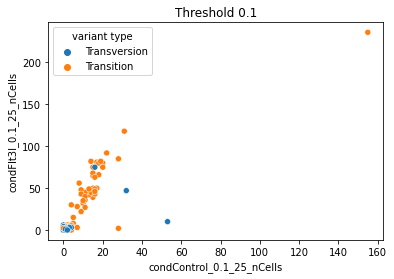

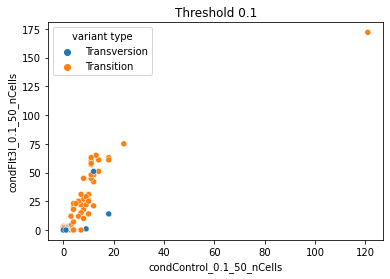

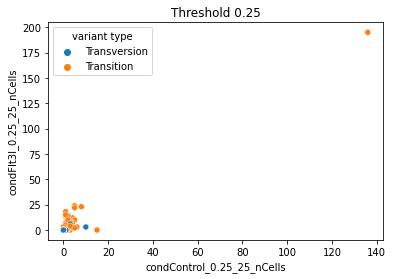

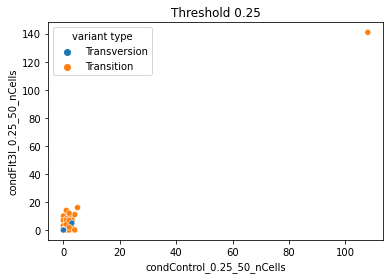

In [40]:
for t in thresholds:
    for rt in read_thresh:
        f = plt.figure()
        sns.scatterplot(x=f"cond{samples[0]}_{t}_{rt}_nCells",y=f"cond{samples[1]}_{t}_{rt}_nCells",hue="variant type",
                        data=variants_df)
        plt.title(f"Threshold {t}")

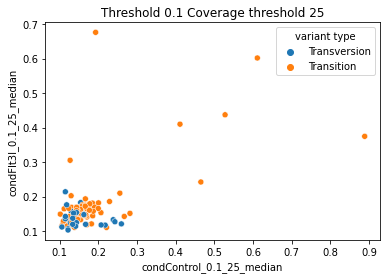

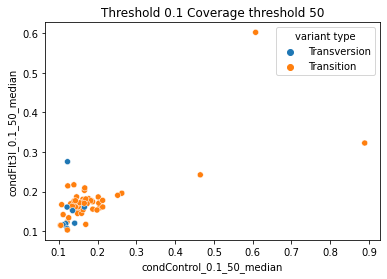

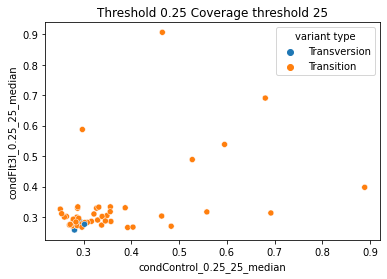

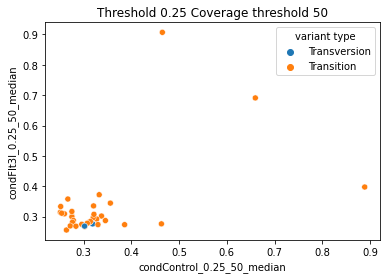

In [41]:
for t in thresholds:
    for rt in read_thresh:
        f = plt.figure()
        sns.scatterplot(x=f"cond{samples[0]}_{t}_{rt}_median",
                        y=f"cond{samples[1]}_{t}_{rt}_median",data=variants_df, hue="variant type")
        plt.title(f"Threshold {t} Coverage threshold {rt}")

ic| t: 0.25, rt: 25


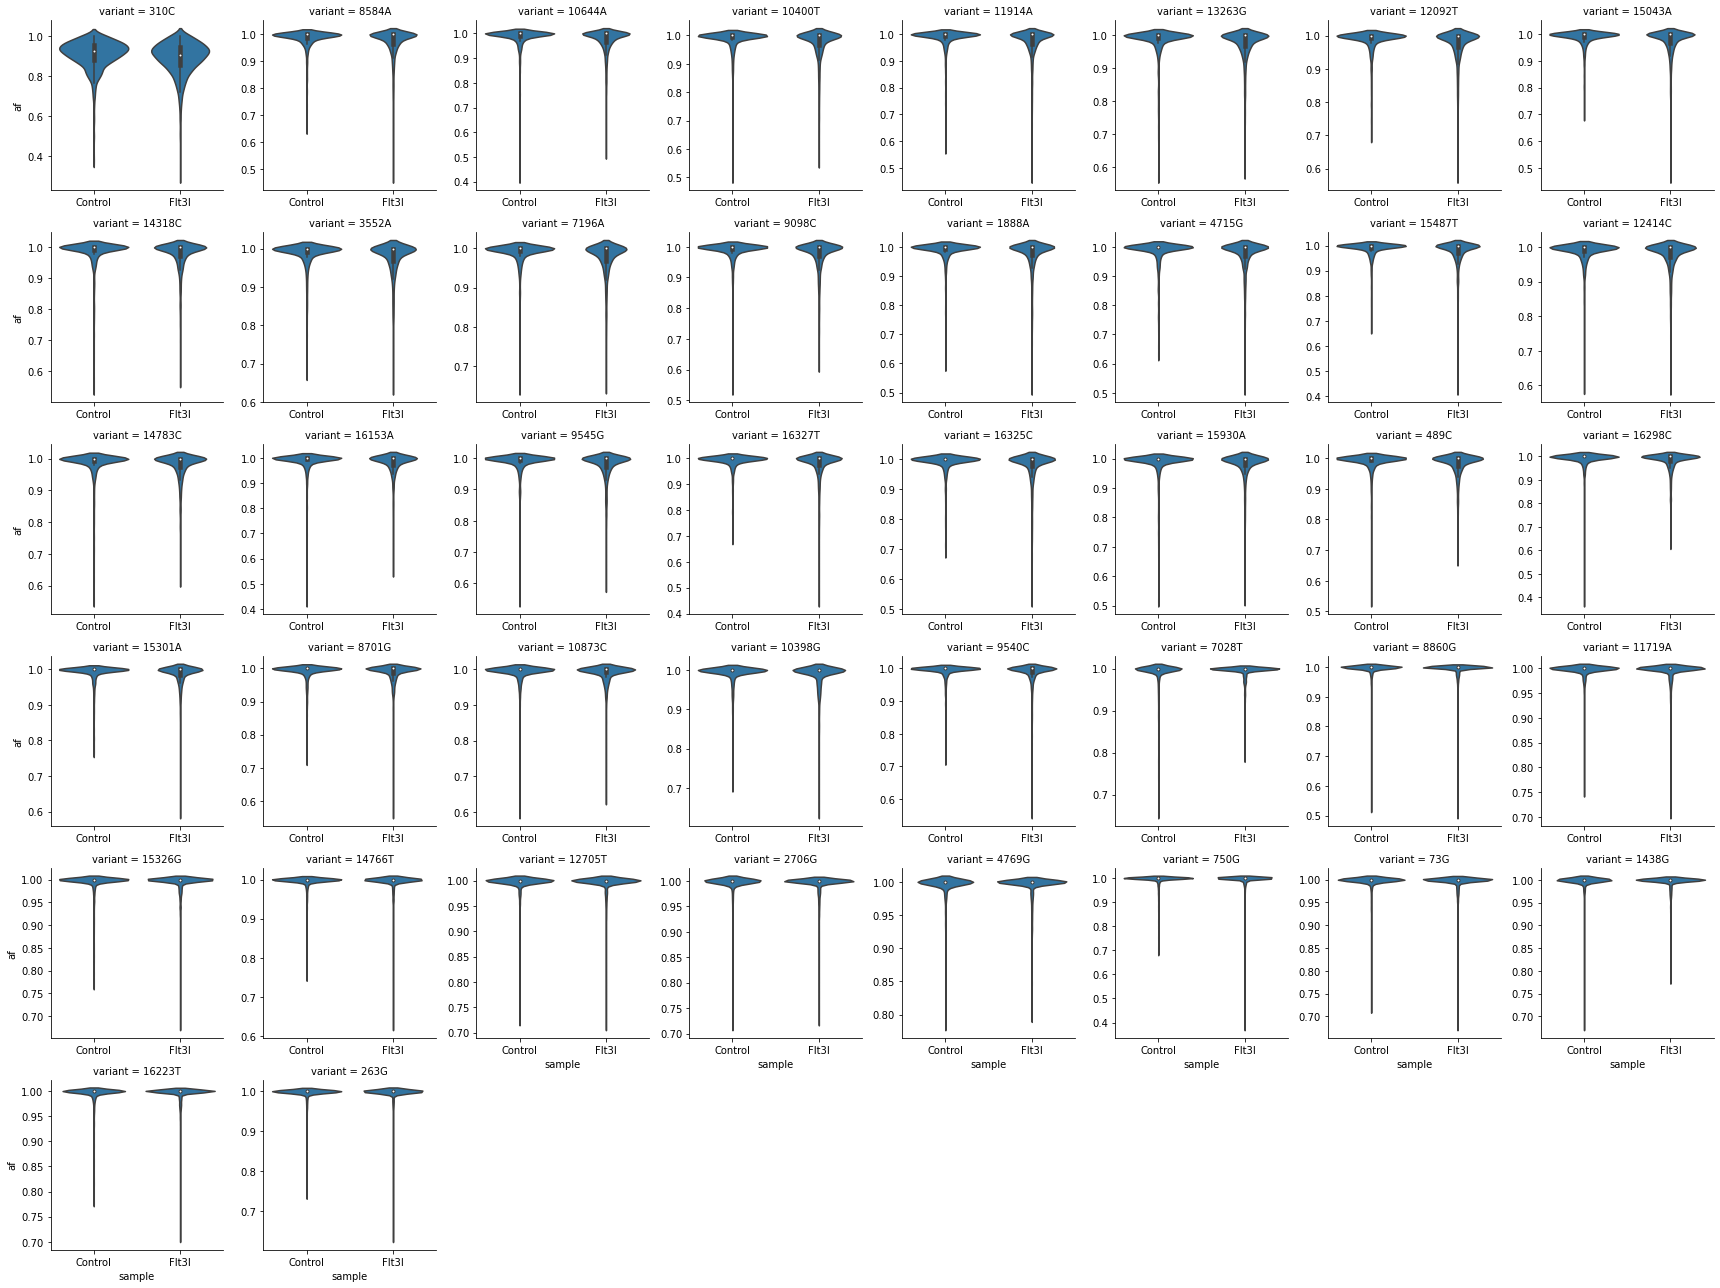

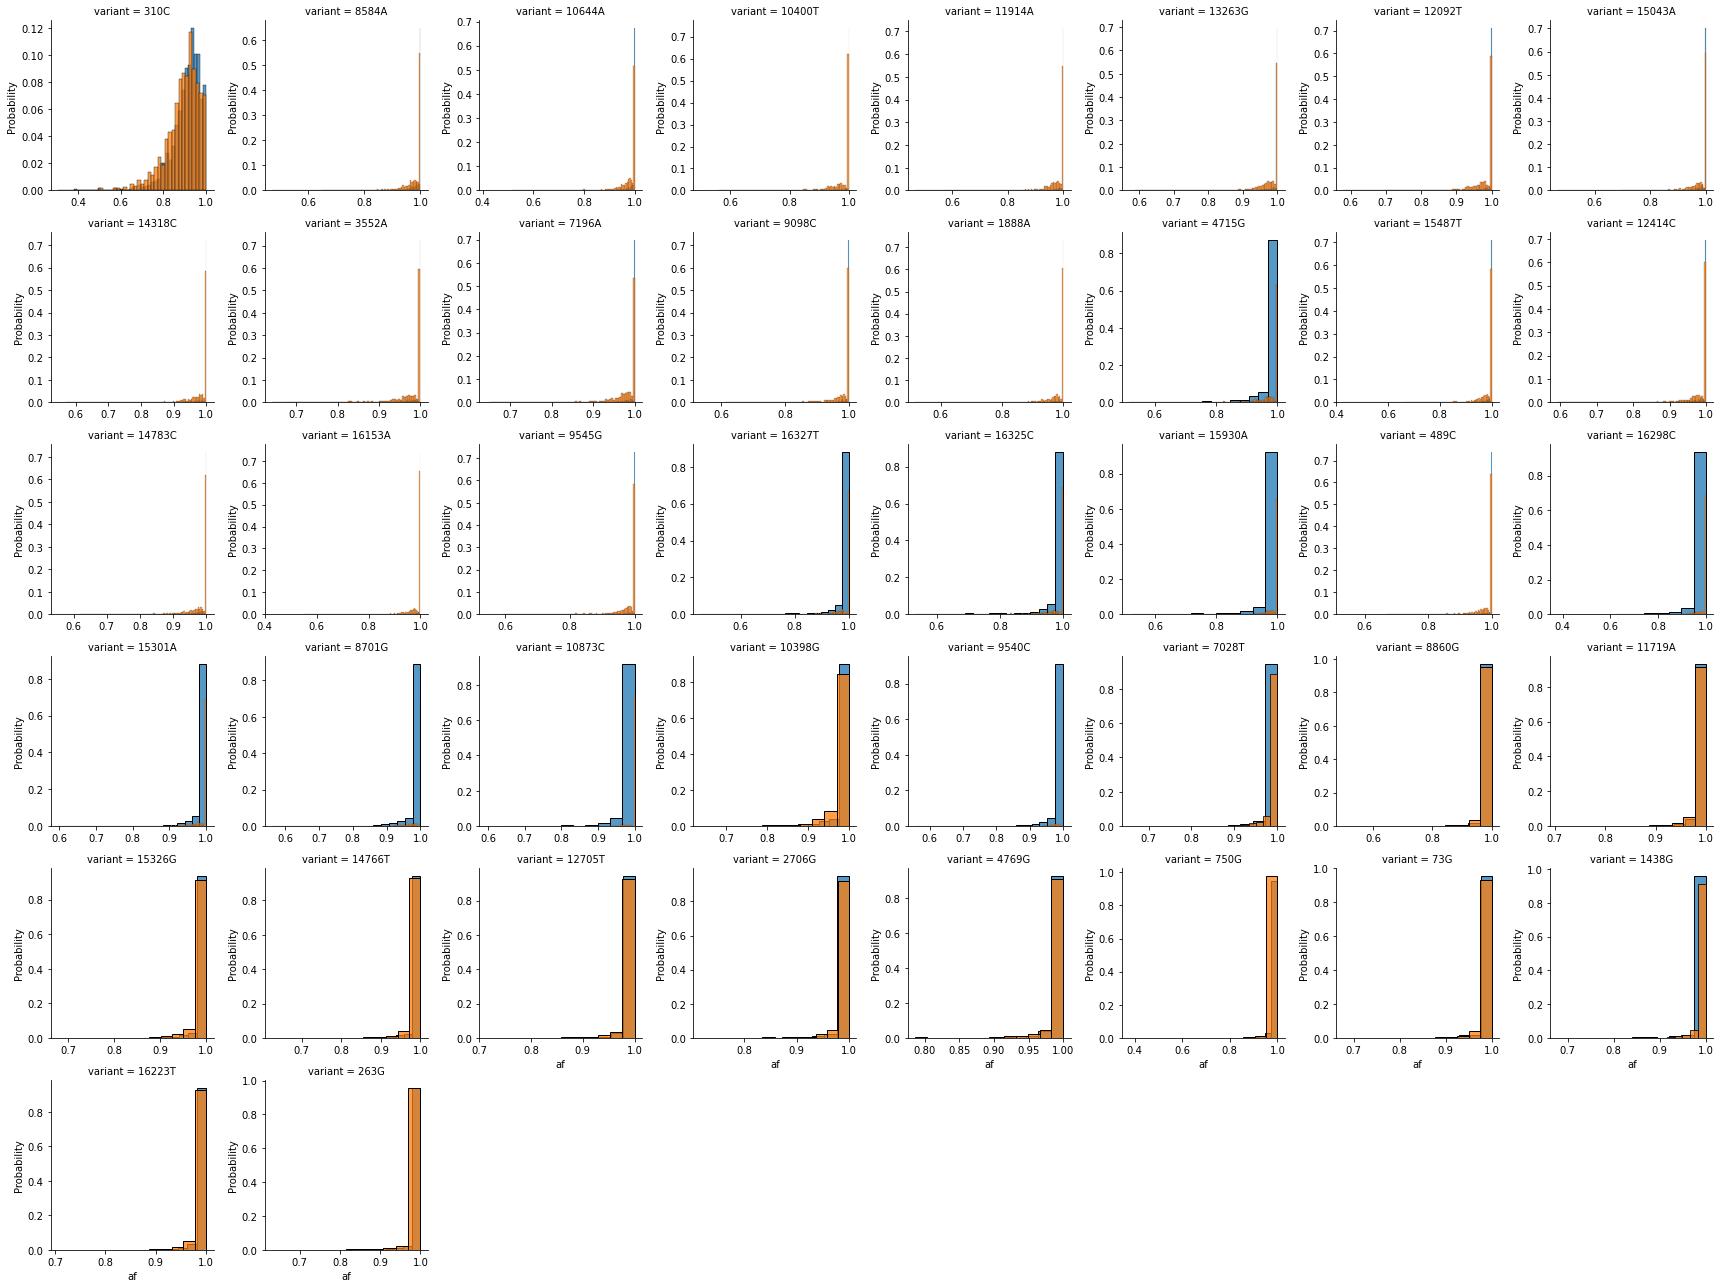

In [42]:
%matplotlib inline
t=0.25
rt=25
clone_var_distributions = create_distributions_samples(t,rt, variants_cell_index_d, af, cells_thresh, ref_cells_thresh, samples=samples)

col_order = clone_var_distributions.groupby("variant").mean()["af"].sort_values().index
g_vln = plot_violin(clone_var_distributions, col_order, x="sample")
g_hist = plot_hist(clone_var_distributions, col_order, hue_col="sample")

ic| t: 0.1, rt: 25


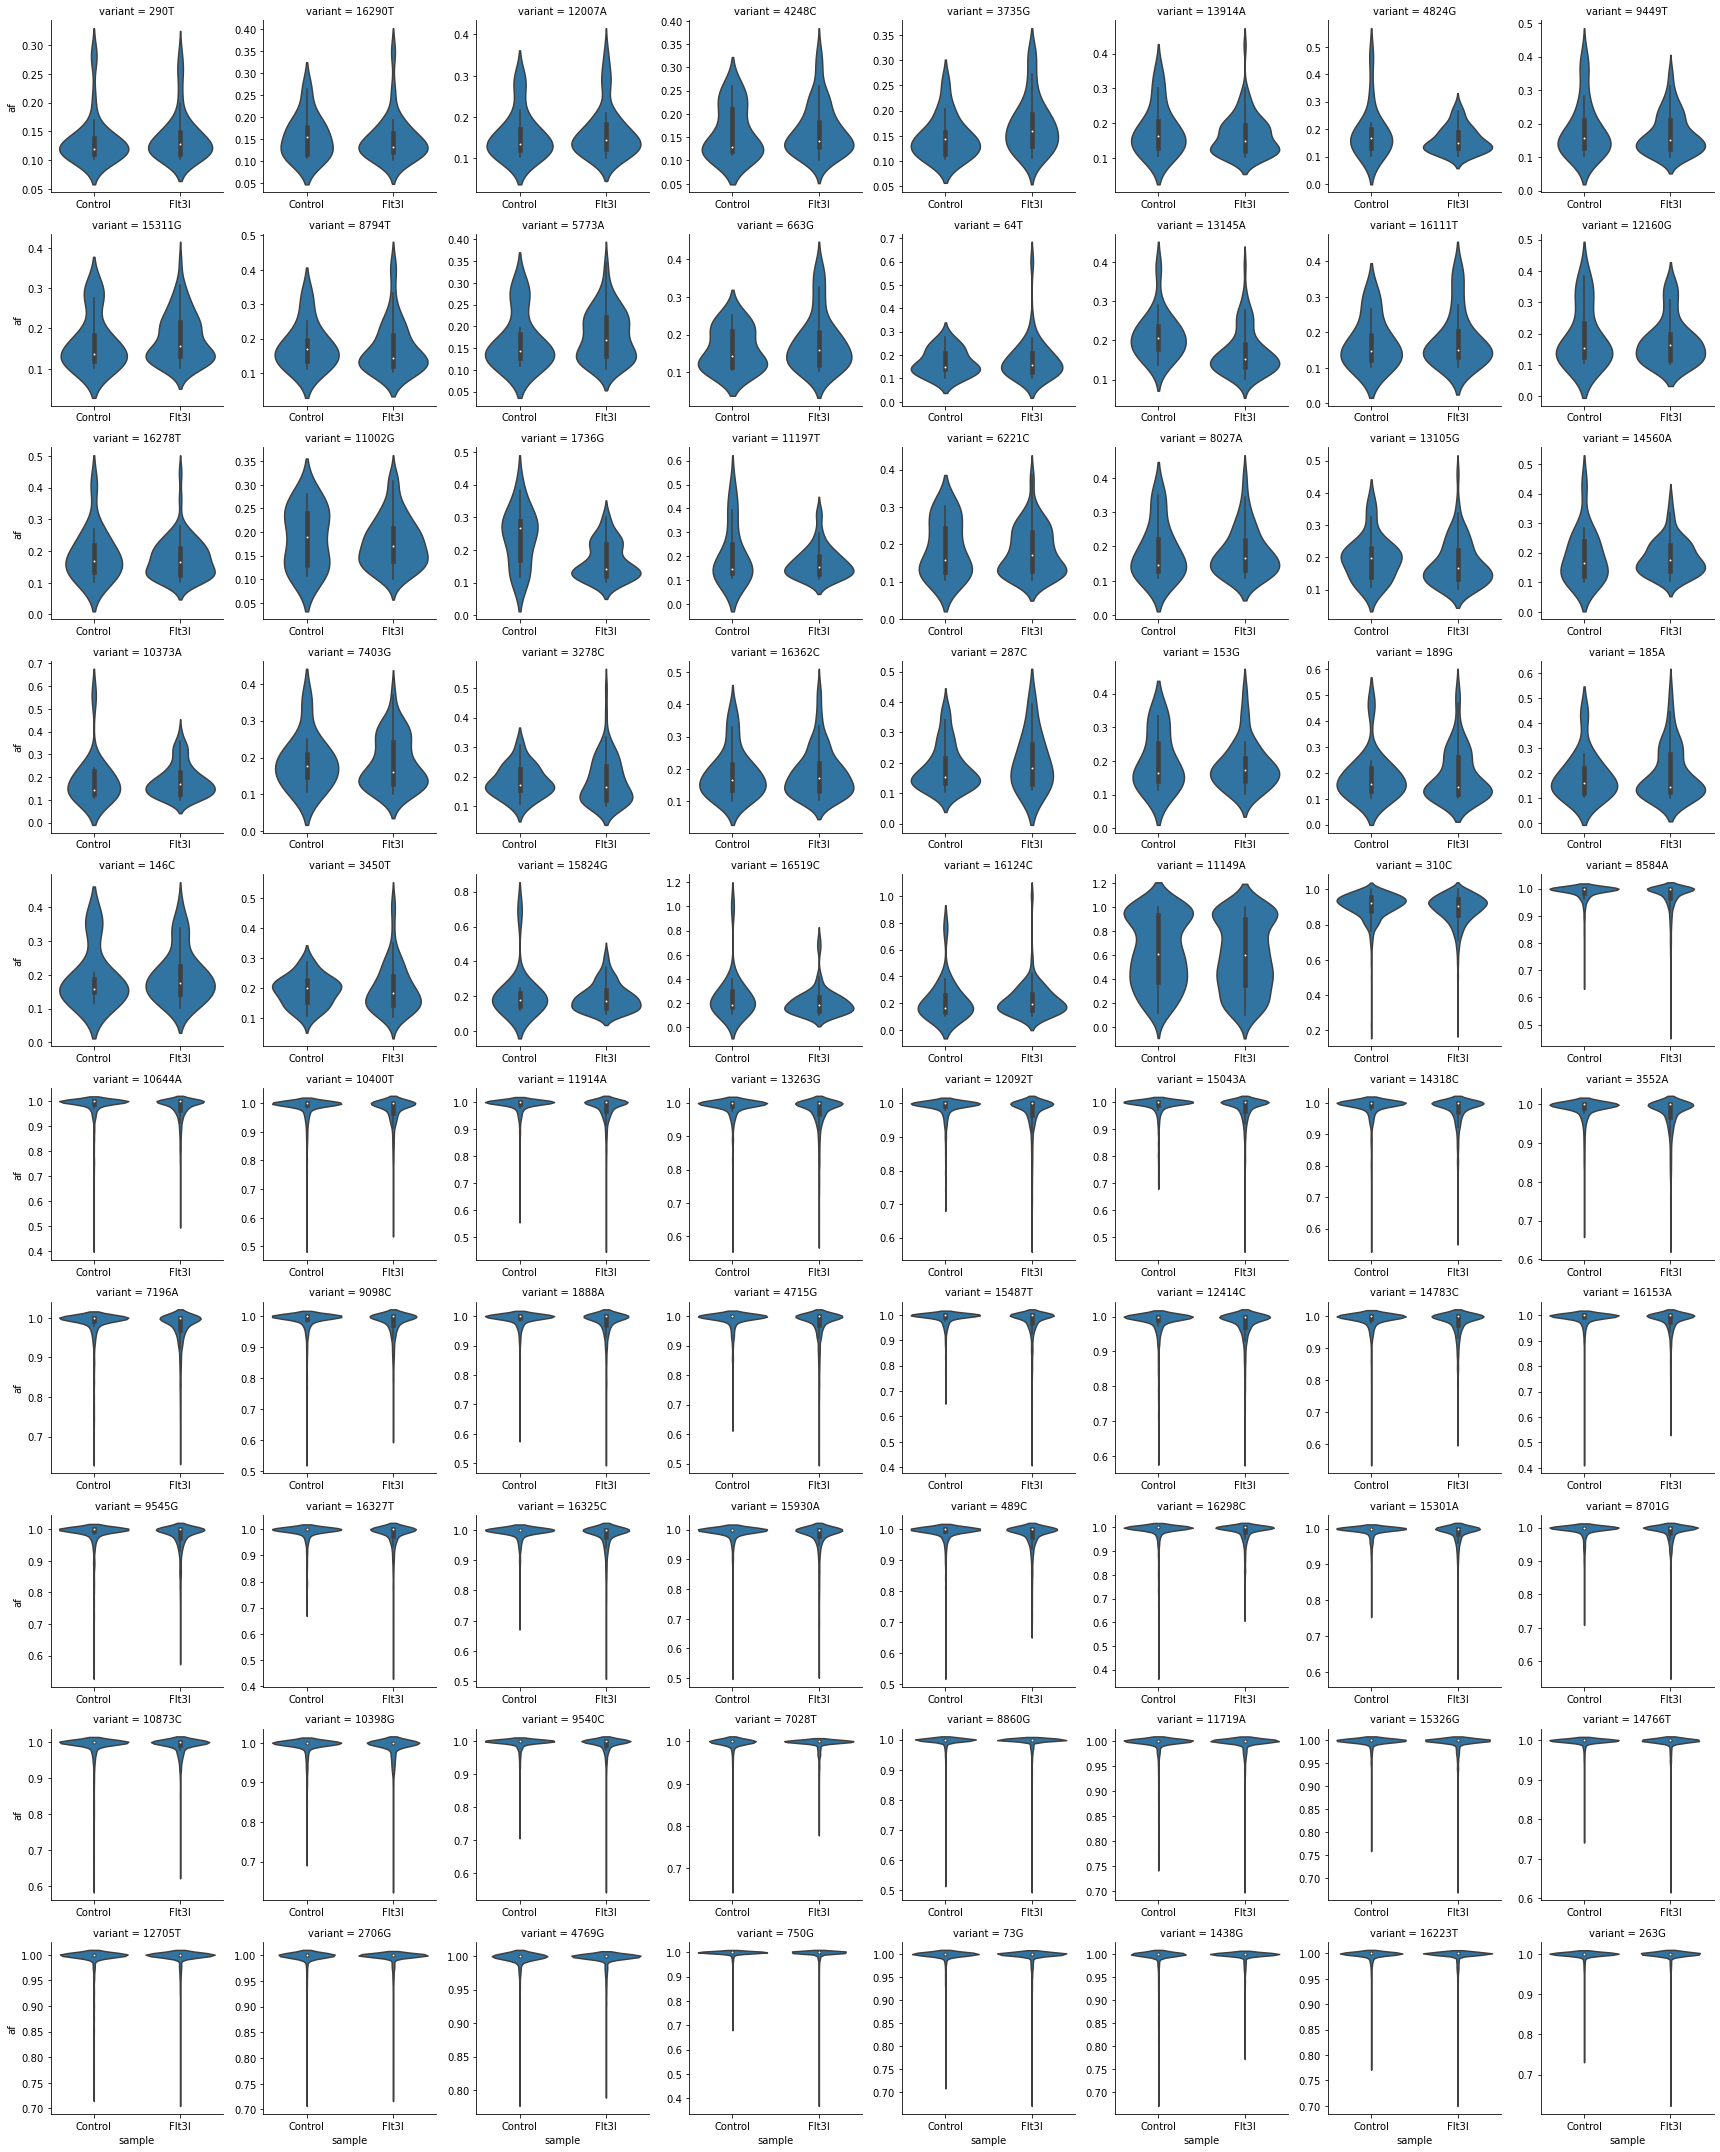

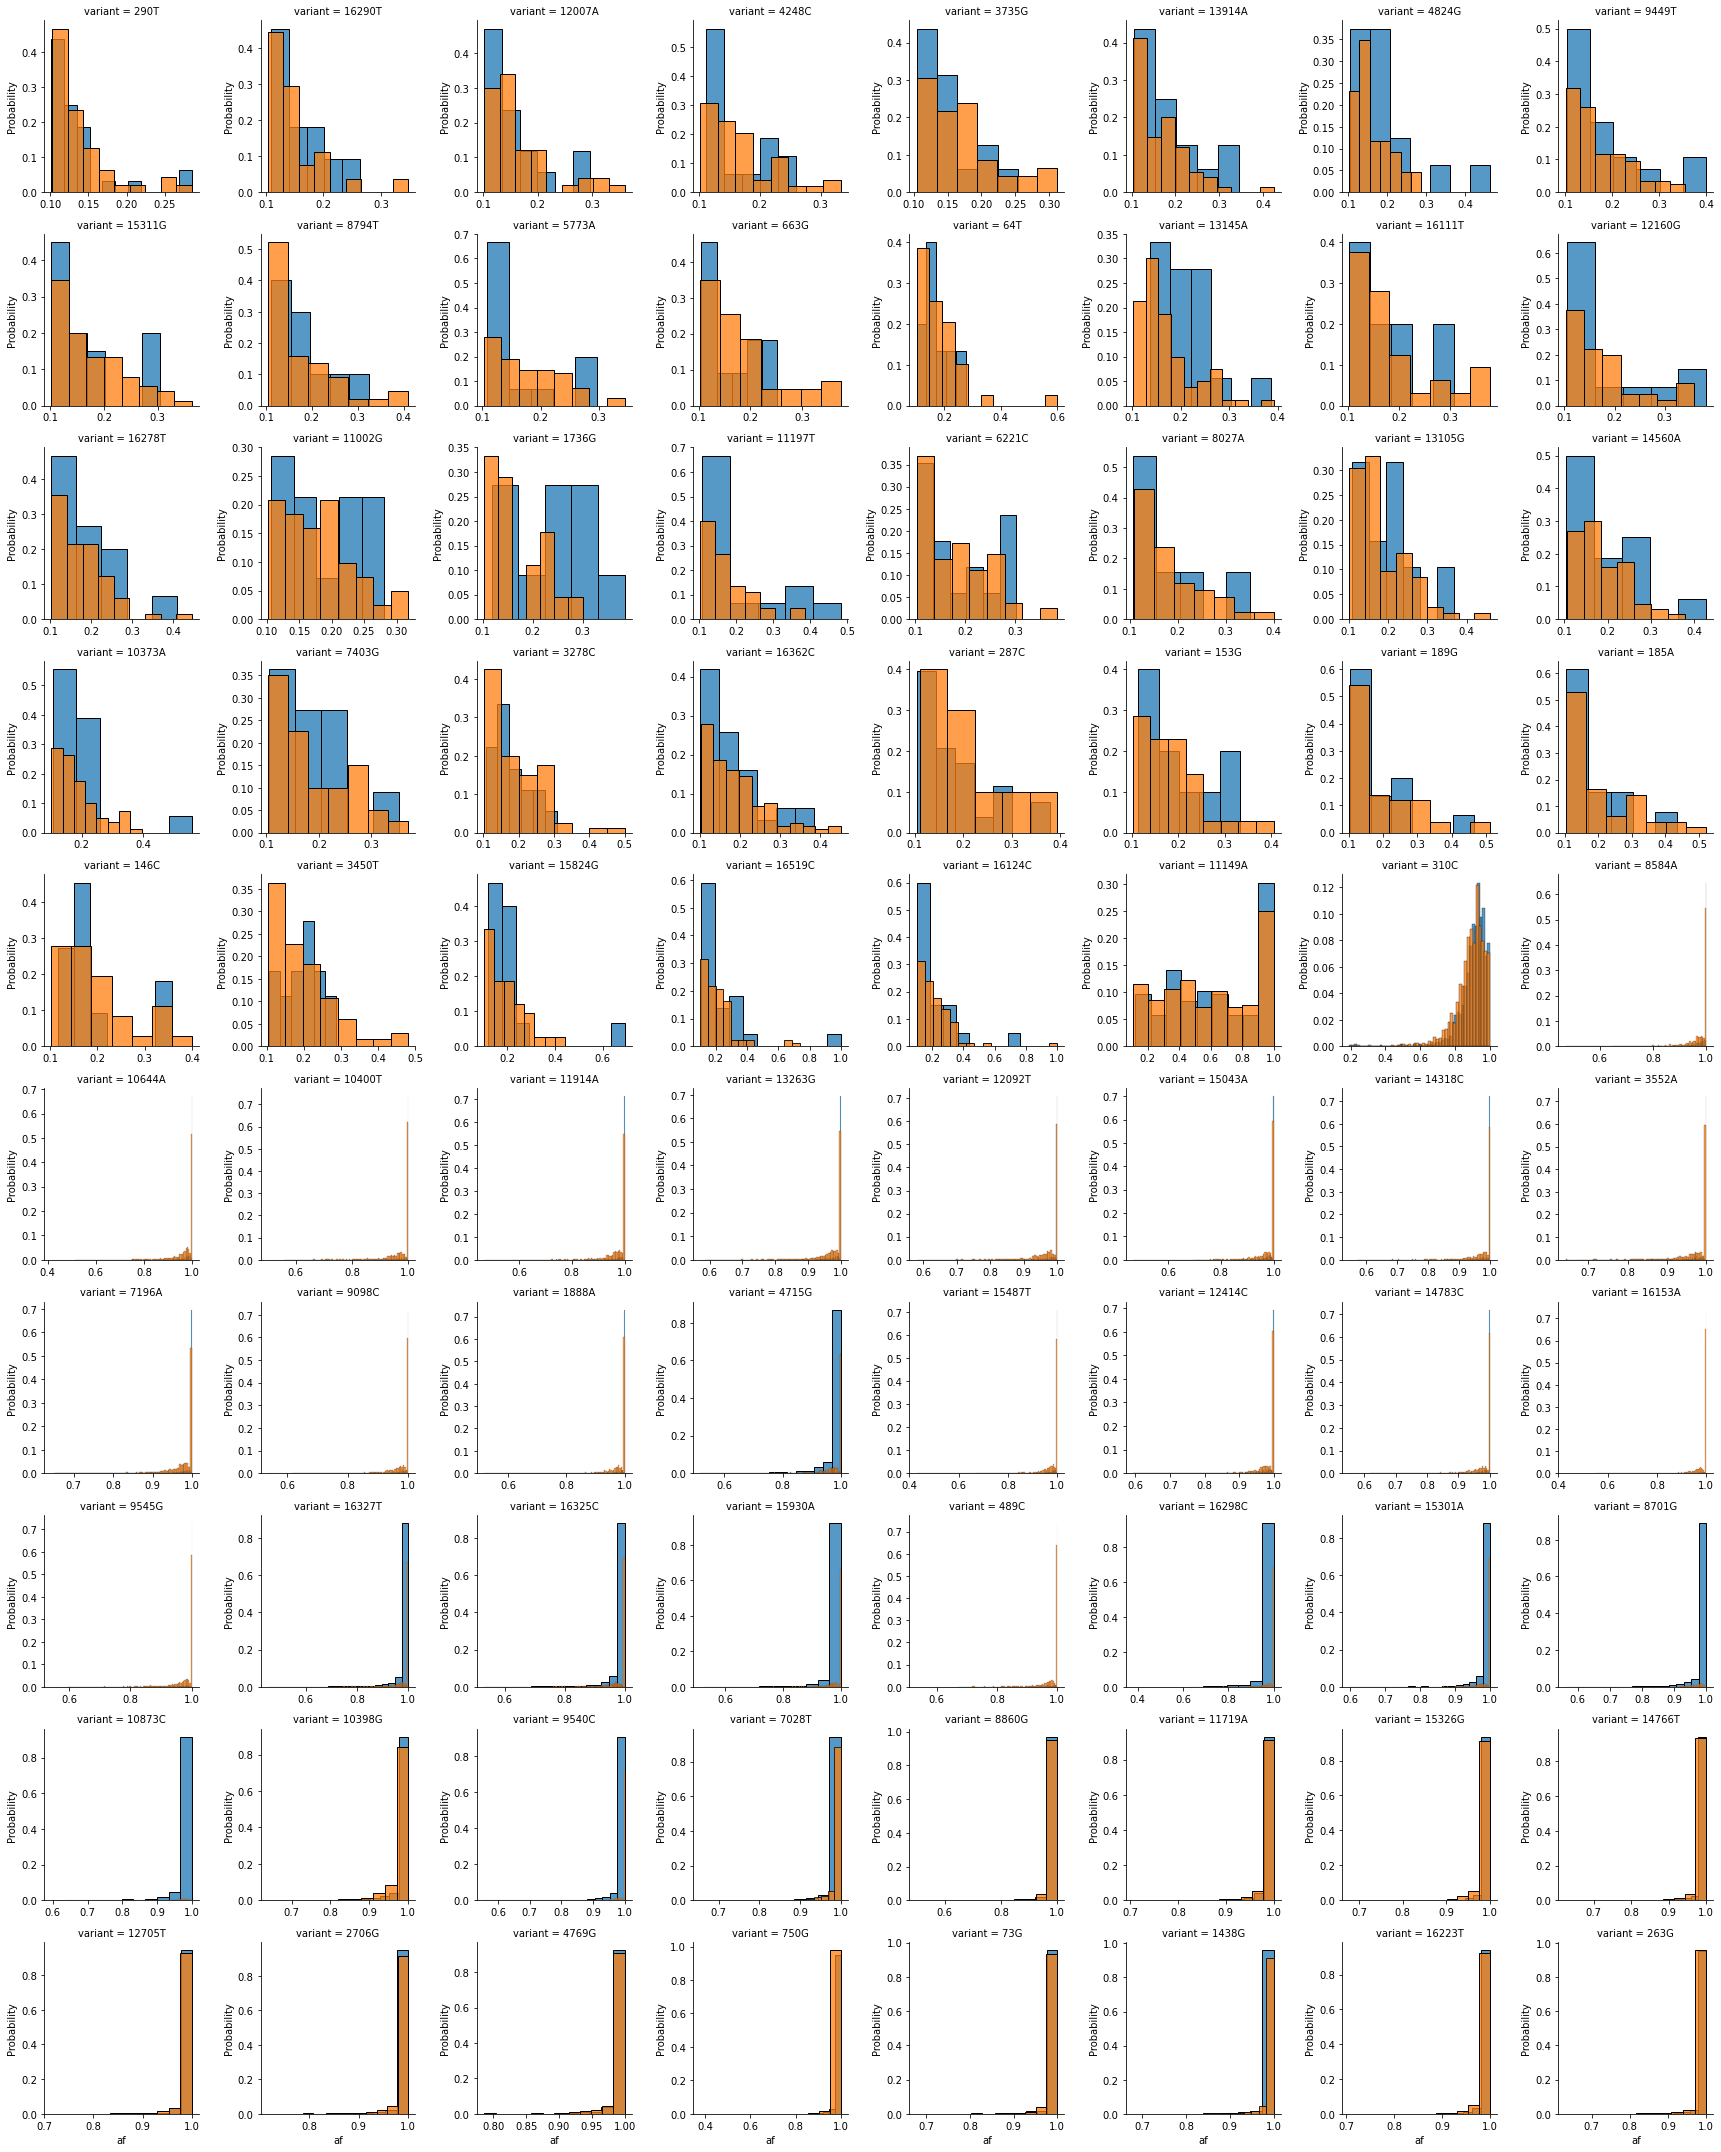

In [43]:
%matplotlib inline
t=0.1
rt=25
clone_var_distributions = create_distributions_samples(t,rt, variants_cell_index_d, af, 
                                                       10, 10, samples=samples)

col_order = clone_var_distributions.groupby("variant").mean()["af"].sort_values().index
g_vln = plot_violin(clone_var_distributions, col_order, x="sample")
g_hist = plot_hist(clone_var_distributions, col_order, hue_col="sample")